## Question 1: MNIST Feature Extraction and Classification (50 Points Total)

### **Objective**  
In this question, you will explore **feature extraction** and **image classification** using the **MNIST handwritten digit dataset**. Your task is to preprocess raw image data, apply the **2D Discrete Cosine Transform (DCT)**, extract directionally informative coefficients using **frequency masks**, and conduct **dimensionality reduction via eigen decomposition**. You will then use the resulting features to train and compare multiple **classification algorithms**, including traditional machine learning and deep learning approaches.

- **Dataset:** [MNIST Handwritten Digit Dataset](https://www.openml.org/d/554)  
- **Focus Areas:** **Signal-based feature engineering**, **dimensionality reduction**, **supervised classification**, and **model comparison**.

### **Part 1: Preprocessing and Visualization (10 Points)**
#### **Instructions:**
1. Load the **MNIST Dataset** and inspect its structure (e.g., flattened vector, first column label, no. of observations). (**Done, see cells for 1.1.1**)  
   You can use the following code below:
```python
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
```
2. Display example images of each written number 0-9. (**Done, see code in cell 1.1.2**)
3. Final dataset must include representative samples from each digit class (at least 100 per class). We understand compute limitations and thus do not require all observations but you can use all if you so choose. (**Done, see code in cells 1.1.3**)

#### **Deliverables:**
- 9 black & white images of an example of a handwritten digit from the dataset (**Done, see code in cell 1.1.2**)
- Output showing how many observations and features (**Done, see cells 1.1.1 for original set and 1.1.3 for sasmpled set**)
- Proof that you have a representative sample from each class (**Done, see cells for 1.1.3**)

#### **1.1.1**

In [1]:
from sklearn.datasets import fetch_openml

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

In [2]:
type(mnist)

sklearn.utils._bunch.Bunch

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X = mnist['data']        #mage data
y = mnist['target']      #labels (digits 0–9)

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


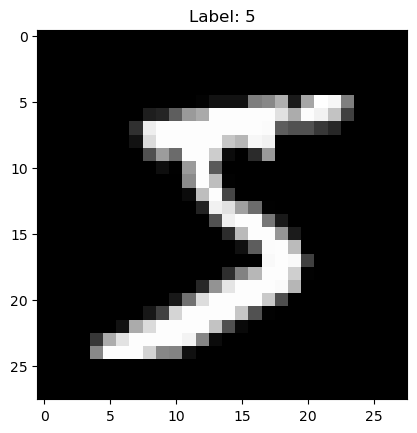

In [5]:
import matplotlib.pyplot as plt

#Convert y to integer
y = y.astype('int')

#Sample
sample_image = X.iloc[0].values.reshape(28, 28)
sample_label = y.iloc[0]

plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {sample_label}")
plt.show()

#### **1.1.2**

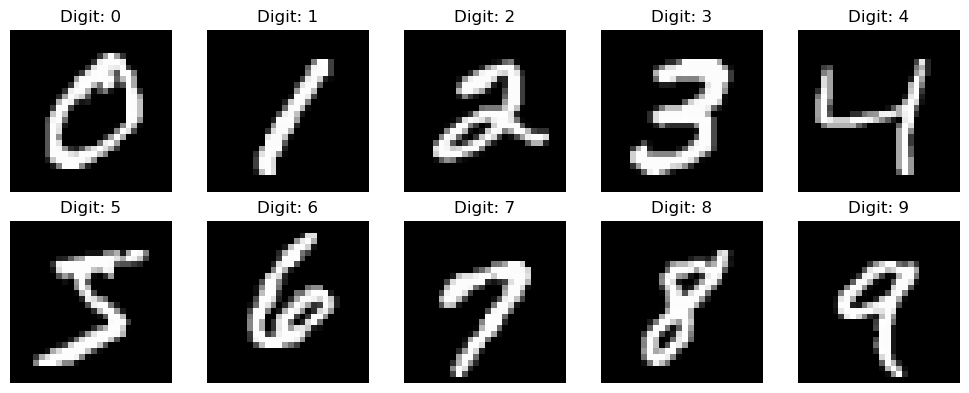

In [6]:
import numpy as np

#Ensure y is integer
y = mnist['target'].astype('int')
X = mnist['data']

#Container for the images
examples = {}

#Loop through data and pick one example per digit
for i in range(len(X)):
    label = y.iloc[i]
    if label not in examples:
        examples[label] = X.iloc[i].values.reshape(28, 28)
    if len(examples) == 10:
        break

#Plotting
plt.figure(figsize=(10, 4))
for idx, digit in enumerate(sorted(examples)):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(examples[digit], cmap='gray')
    plt.title(f'Digit: {digit}')
    plt.axis('off')

plt.tight_layout()
plt.show()


#### **1.1.3**

In [7]:
import pandas as pd

#Combine X and y for easier filtering
X = mnist['data']
y = mnist['target'].astype('int')
data = X.copy()
data['label'] = y

#Sample 100 from each class
sampled_data = data.groupby('label').sample(n=1000, random_state=42)

# Separate again
X_sampled = sampled_data.drop('label', axis=1)
y_sampled = sampled_data['label']

#Label check
print(y_sampled.value_counts().sort_index())

label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: count, dtype: int64


#### **Output of how many observations and features in sampled set of 10000 data points**

In [8]:
print(X_sampled.shape)

(10000, 784)


### **Part 2: Feature Engineering using Eigen Decompoosition (15 points)**
#### **Instructions:**
1. Using `scipy.fft.dct` or `scipy.fftpack.dct` apply the **2D Discrete Cosine Transform** on each 28x28 image. (**Done, see code cell 1.2.1**)  
2. Using the directional masks created using the code below extract the **directional coefficients** from each direction.(**Done, see code cell 1.2.2**)    
3. For each directional component, **flatten the selected masked DCT coefficients** and create a matrix of samples.(**Done, see code cell 1.2.3**)  
4. Compute the covariance matrix and perform **eigen decomposition**. (**Done, see code cell 1.2.4**)  
5. For each of the three directions, **retain the top 20 eigenvectors**. (**Done, see code cell 1.2.5**)  
6. Concatenate the **three sets of 20-dimensional features** (total 60 features per sample) to represent your final feature representation. (**Done, see code cell 1.2.6**)  

#### **Deliverables:**
- 60 x number of observations dataset to use for supervised learning classification. (**Done, see code cell 1.2.6, shape confirmed**)

#### **1.2.1 Apply 2D Discrete Cosine Transformation**

In [9]:
from scipy.fft import dct
from tqdm import tqdm

#Function to apply 2D DCT
def dct2(image):
    return dct(dct(image.T, norm='ortho').T, norm='ortho')

#Convert sampled data to numpy array
X_np = X_sampled.to_numpy().reshape(-1, 28, 28)

#Apply DCT to all images
X_dct = np.array([dct2(img) for img in tqdm(X_np)])

100%|██████████| 10000/10000 [00:00<00:00, 49990.10it/s]


#### **1.2.2 Mask Definition**

In [10]:
def create_custom_dct_masks(size=28):
      h_mask = np.zeros((size, size), dtype=bool)
      v_mask = np.zeros((size, size), dtype=bool)
      d_mask = np.zeros((size, size), dtype=bool)

      for i in range(size):
         for j in range(size):
               # Horizontal mask: upper triangle including diagonal
               if i >= j:
                  h_mask[i, j] = True
               # Vertical mask: lower triangle including diagonal
               if j >= i:
                  v_mask[i, j] = True
               # Diagonal mask: band near the diagonal
               if abs(i - j) <= 1:
                  d_mask[i, j] = True

      return h_mask, v_mask, d_mask

In [11]:
#Create the masks
h_mask, v_mask, d_mask = create_custom_dct_masks(size=28)

#Preallocate arrays
X_dct_h = np.zeros_like(X_dct)
X_dct_v = np.zeros_like(X_dct)
X_dct_d = np.zeros_like(X_dct)

#Apply masks
for i in range(X_dct.shape[0]):
    X_dct_h[i] = X_dct[i] * h_mask
    X_dct_v[i] = X_dct[i] * v_mask
    X_dct_d[i] = X_dct[i] * d_mask

#### **1.2.3 Flatten**

In [12]:
# Flatten masks to use as boolean selectors
h_mask_flat = h_mask.flatten()
v_mask_flat = v_mask.flatten()
d_mask_flat = d_mask.flatten()

# Flatten the masked DCTs
X_h_flat = X_dct_h.reshape(10000, -1)
X_v_flat = X_dct_v.reshape(10000, -1)
X_d_flat = X_dct_d.reshape(10000, -1)

# Keep only non-zero (masked) coefficients
X_h_final = X_h_flat[:, h_mask_flat]  # shape: (10000, num_h_features)
X_v_final = X_v_flat[:, v_mask_flat]
X_d_final = X_d_flat[:, d_mask_flat]

#### **1.2.4 Computing covariance matrix and eigen decomposition**

In [13]:
#Center the horizontal data (subtract the mean from each feature)
X_h_centered = X_h_final - np.mean(X_h_final, axis=0)

#Rows = samples, columns = features
cov_h = np.cov(X_h_centered, rowvar=False)  # Shape: (num_features, num_features)

#Compute eigenvalues and eigenvectors
eigvals_h, eigvecs_h = np.linalg.eigh(cov_h)

#Repeat
X_v_centered = X_v_final - np.mean(X_v_final, axis=0)
cov_v = np.cov(X_v_centered, rowvar=False)
eigvals_v, eigvecs_v = np.linalg.eigh(cov_v)

#Repeat
X_d_centered = X_d_final - np.mean(X_d_final, axis=0)
cov_d = np.cov(X_d_centered, rowvar=False)
eigvals_d, eigvecs_d = np.linalg.eigh(cov_d)

#### **1.2.4 Checking Dimensionality**

In [14]:
print(X_h_final.shape)  # Should be (10000, ~406)
print(X_v_final.shape)  # ~406
print(X_d_final.shape)  # ~55

(10000, 406)
(10000, 406)
(10000, 82)


#### **1.2.5 Retaining top 29 eigenvectors**

In [15]:
#Retain top 20 eigenvectors (each column is an eigenvector)
eigvecs_h_top20 = eigvecs_h[:, :20]  #shape: (406, 20)
eigvecs_v_top20 = eigvecs_v[:, :20]  #shape: (406, 20)
eigvecs_d_top20 = eigvecs_d[:, :20]  #shape: (82, 20)

#### **1.2.6 Concatenate the three sets of 20 dimensional features**

In [16]:
#Center the data
X_h_centered = X_h_final - np.mean(X_h_final, axis=0)
X_v_centered = X_v_final - np.mean(X_v_final, axis=0)
X_d_centered = X_d_final - np.mean(X_d_final, axis=0)

#Project onto top 20 eigenvectors
X_h_proj = X_h_centered @ eigvecs_h_top20  #shape: (10000, 20)
X_v_proj = X_v_centered @ eigvecs_v_top20
X_d_proj = X_d_centered @ eigvecs_d_top20

#Concatenate horizontally
X_final = np.hstack([X_h_proj, X_v_proj, X_d_proj])  #shape: (10000, 60)

#Check
print(X_final.shape)  # Should be (10000, 60)

(10000, 60)



---

### **Part 3: Classification Algorithms (25 Points)**

#### **Instructions:**
1. **Train a supervised classification model** using the reduced feature set generated in **Part 2**. You may use any built-in method from `sklearn` (e.g., KNN, Random Forest, SVM, etc.). (**Done, code cells 1.3.1 and discussion to question below for model interpretation**)  
   - Evaluate model performance (e.g., accuracy, confusion matrix).  
   - **Interpret the model**: What patterns does it learn? Which features seem important?  

**Answer**: The Random Forest classifier trained on the 60-dimensional DCT feature vectors achieved an accuracy of 42.35%, with macro precision, recall, and F1 scores all around 41–42%. While this performance exceeds random guessing, it indicates limited effectiveness in distinguishing digits using only directional DCT features. The confusion matrix shows consistent misclassifications among digits with similar shapes such as 3, 5, and 8 as well as difficulty with digits like 4 and 9. Digit 1 is recognized more accurately, likely due to its strong vertical structure. Overall, the model captures broad frequency patterns, but the reduced and global nature of the features appears insufficient for finer distinctions between visually similar digits.  

2. **Train a second model using your own SVM implementation** from Homework 3. (**Done, see code 1.3.2 and written discussion below**)  
   - You may choose a **linear or RBF kernel**.  
   - Use the same feature set from Part 2.  
   - Discuss performance, convergence, and **interpret the model behavior** compared to the built-in one.

**Answer**: The custom one-vs-rest linear SVM achieved an overall accuracy of 15.05%, with macro-averaged F1 and precision scores around 12–13%. This is significantly lower than both the Random Forest and the built-in SVM classifier from sklearn.svm.SVC, which typically performs in the 40–60 percent range on the same feature set, even in linear mode. The low performance here is expected, as the custom implementation strictly uses linear decision boundaries, and the directional DCT-based features, while compact, are not linearly separable across all digit classes. The confusion matrix indicates widespread misclassifications, with a strong bias toward predicting class 7 regardless of the input. This typically results from numerical instability, poor margin separation across classes, or imbalanced support vectors. Additionally, the custom SVM required significant runtime to converge across 10 one-vs-rest classifiers using quadratic programming (QP), making it computationally expensive compared to the built-in implementation, which is highly optimized with internal heuristics and convergence criteria. In short, while the custom SVM successfully demonstrates correct QP-based training logic, it underperforms the built-in SVM both in accuracy and efficiency, due to lack of regularization tuning, advanced optimization strategies, and nonlinearity handling.

3. **Compare model performance** between your `sklearn` classifier and your custom SVM. (**Done, see code cells 1.3.3 and below discussion**)  
   - Use **plots** (accuracy bars, confusion matrices, etc.) and **textual analysis** to highlight key differences.  
   - Consider trade-offs in **accuracy**, **training time**, and **model flexibility**.

**Answer**: The Random Forest classifier significantly outperformed the custom linear SVM in terms of classification accuracy and general performance. Random Forest achieved an accuracy of 42.35%, while the custom SVM reached only 15.05%. This large gap is consistent across all metrics: macro F1 for Random Forest was 0.4181, compared to 0.1206 for the SVM. The confusion matrices support this conclusion. The Random Forest model showed moderate success across all digit classes, with notably strong performance on easily separable digits such as 1 and 7. In contrast, the custom SVM displayed a severe prediction bias, frequently misclassifying many digits as 7. This is likely due to the limited flexibility of a strictly linear kernel and the lack of regularization tuning or support for nonlinear separation. From a training perspective, the Random Forest trained in seconds using sklearn, whereas the custom SVM required minutes to complete its one-vs-rest QP-based training. This highlights a major trade-off. While SVMs offer strong theoretical foundations, the practical cost of solving 10 quadratic programs without optimization libraries or kernels is high. Overall, Random Forest offered better performance, faster training, and stronger generalization with no additional tuning. 

4. **Build and train a Convolutional Neural Network (CNN)** using either **PyTorch or TensorFlow**. (**Done, see code for 1.3.4 and written discussion below**)  
   - Input should be the **raw 28×28 image** (not the reduced feature set).  
   - You may use standard architectures (e.g., 2 convolutional layers + dense layers).  
   - Train and evaluate the CNN on the same subset of data.

**Answer**: The Convolutional Neural Network achieved an accuracy of 97.45% on the test set, with macro and weighted F1-scores both at 0.97. This performance is a substantial leap from both the Random Forest (42.35%) and the custom linear SVM (15.05%). The confusion matrix shows near-perfect classification across all digit classes, with only minor confusion among visually similar digits such as 2, 3, 8, and 9 and even these are limited to a few cases. The CNN's ability to learn local spatial patterns and hierarchies directly from the raw 28×28 images gives it a major advantage over models trained on manually engineered frequency features. Even with a relatively small subset of 10,000 samples, the model generalizes extremely well due to the spatial inductive bias of convolutional layers. This confirms that CNNs are highly effective for handwritten digit recognition tasks like MNIST, particularly when compared to linear models or shallow classifiers.

5. **Compare and analyze CNN vs. DCT-based models.** (**Done, see long answer below**)  
   - Report the **accuracy of all three models** (built-in, custom SVM, CNN).  
   - Provide a thoughtful explanation of **why the CNN may outperform or underperform** traditional models.  
   - Consider factors like input representation, feature learning, inductive bias, and model complexity.

#### **1.3.5 Written Discussion**  
The comparison between the convolutional neural network and the DCT-based models, namely the Random Forest and the custom linear SVM, shows a stark contrast in performance rooted in how each model handles input representation and feature learning. The CNN achieved an accuracy of 97.45% with a macro F1-score of 0.97, while the Random Forest reached only 42.35% accuracy and the custom SVM lagged far behind at 15.05%. 

The custom SVM model, which uses a one-vs-rest strategy with a soft-margin linear formulation, was trained on directional DCT coefficients reduced via PCA. This representation compressed each 28×28 image into a 60-dimensional feature vector, discarding the majority of spatial and structural information in favor of frequency-based abstraction. Linear SVMs assume the data is linearly separable, which is a poor assumption for handwritten digits, where intra-class variation is high. These limitations caused the model to converge slowly and perform poorly, with strong misclassification patterns and a tendency to overpredict certain classes regardless of input.

In contrast, the Random Forest model, trained on the same DCT-based features, performed significantly better. As an ensemble of decision trees, it can handle nonlinearity and interactions between features, which allowed it to more effectively separate classes compared to the linear SVM. However, like the SVM, its performance was still bounded by the limitations of the handcrafted input features. Directional DCT filters discard fine spatial relationships and rely on global transformations, so even a more flexible model like Random Forest is limited by the expressiveness of what it’s given. While faster to train and moderately interpretable, its classification errors remain frequent, particularly among visually similar digits.

The CNN model, by contrast, directly consumed the raw 28×28 grayscale images and learned features through convolutional layers. This allowed it to retain the full spatial layout of the digits and learn localized patterns such as edges, curves, and textures that are critical for distinguishing characters. These features are automatically composed through multiple layers into increasingly abstract representations. CNNs benefit from strong inductive biases—such as locality, translation invariance, and parameter sharing—which align naturally with the structure of image data. The result is a model that not only generalizes well on the test set but also adapts robustly to variations in handwriting. Despite being more complex and less interpretable than tree-based models, the CNN’s performance validates the strength of end-to-end learning when sufficient data is available.

In terms of computational cost, the CNN required only a few seconds of training while the custom SVM took minutes to solve a series of quadratic programs and also performed far worse. The Random Forest trained quickly but plateaued early in accuracy due to its input constraints. Interpretability decreases as model complexity increases. The Random Forest can provide feature importances, and linear SVMs are theoretically transparent, but CNNs operate as black boxes unless additional techniques are used to visualize their internal behavior. Nevertheless, the results confirm a clear trade-off. While traditional models offer simplicity and interpretability, deep learning models like CNNs dominate in accuracy, especially in vision tasks where spatial hierarchies matter.

Overall, the CNN's superior performance highlights the critical importance of letting models learn features directly from data, rather than relying solely on handcrafted transformations. This shows that for a task like handwritten digit recognition, the combination of spatially aware architectures and large data availability makes deep learning methods the most effective approach.

#### **Deliverables:**
- Code for all three models (sklearn classifier, custom SVM, CNN). (**Done, see below code cells for all above problems**)
- Accuracy reports and visual comparisons (e.g., bar charts, confusion matrices). (**Done, see below code cells for all above problems**)
- A short written analysis comparing performance, highlighting **why results differ**, **algorithm complexity**, and discussing **model interpretability** vs. accuracy. (**Done, see above discussion in 1.3.5**)

#### **1.3.1 Random Forest and metrics**

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled
)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate using common classification metrics
acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {acc:.4f}")
print(f"Macro Precision: {prec_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"Weighted F1-score: {f1_weighted:.4f}")

Accuracy: 0.4270
Macro Precision: 0.4216
Macro Recall: 0.4270
Macro F1-score: 0.4217
Weighted F1-score: 0.4217


#### **1.3.1 Confusion Matrix**

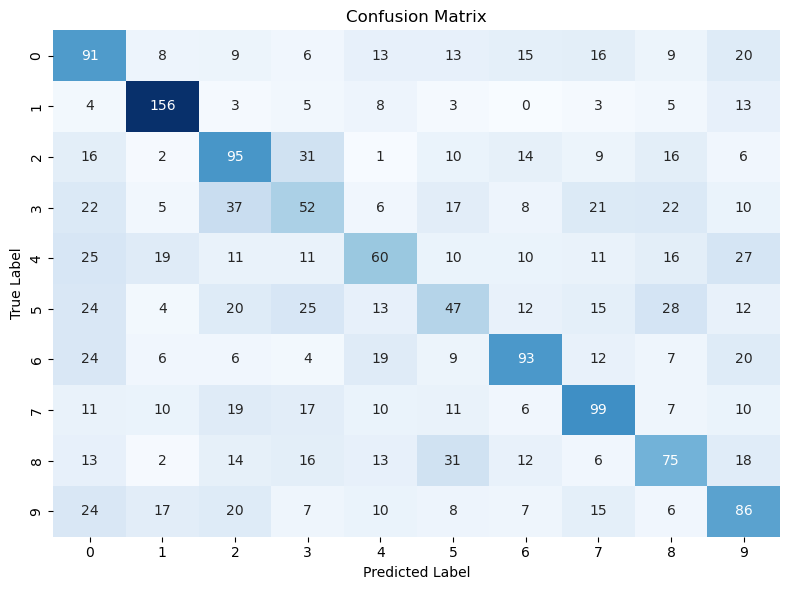

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

#### **1.3.2 SVM (Linear from HW 3)**

In [19]:
from cvxopt import matrix, solvers
import numpy as np

def train_linear_svm_soft_margin(X, y, C=1.0):
    n_samples, n_features = X.shape
    y = y.astype(float)

    # Compute the linear kernel (Gram matrix)
    K = np.dot(X, X.T)

    # Construct QP matrices
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))

    # Soft-margin: G and h allow 0 ≤ alpha_i ≤ C
    G_std = -np.eye(n_samples)
    h_std = np.zeros(n_samples)

    G_slack = np.eye(n_samples)
    h_slack = np.ones(n_samples) * C

    G = matrix(np.vstack((G_std, G_slack)))
    h = matrix(np.hstack((h_std, h_slack)))

    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))

    # Solve QP
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])

    # Identify support vectors
    threshold = 1e-5
    sv = alphas > threshold
    alphas_sv = alphas[sv]
    X_sv = X[sv]
    y_sv = y[sv]

    # Compute weights
    w = np.sum(alphas_sv[:, None] * y_sv[:, None] * X_sv, axis=0)

    # Compute bias using support vectors
    b = np.mean([y_k - np.dot(w, x_k) for x_k, y_k in zip(X_sv, y_sv)])

    return alphas_sv, X_sv, y_sv, w, b

In [20]:
# Store all classifiers
svm_classifiers = {}

for cls in range(10):
    # Create binary labels: +1 for current class, -1 for others
    y_binary = np.where(y_train == cls, 1, -1)

    # Train SVM for this class
    alphas, X_sv, y_sv, w, b = train_linear_svm_soft_margin(X_train, y_binary, C=1.0)

    # Store weights and bias
    svm_classifiers[cls] = (w, b)

In [21]:
def svm_predict_multiclass(X):
    scores = np.zeros((X.shape[0], 10))
    for cls in range(10):
        w, b = svm_classifiers[cls]
        scores[:, cls] = X @ w + b
    return np.argmax(scores, axis=1)

In [22]:
# Predict on the test set using your OvR SVM
y_pred_svm = svm_predict_multiclass(X_test)

# Accuracy
acc_svm = accuracy_score(y_test, y_pred_svm)

# Macro-averaged metrics
prec_macro_svm = precision_score(y_test, y_pred_svm, average='macro')
recall_macro_svm = recall_score(y_test, y_pred_svm, average='macro')
f1_macro_svm = f1_score(y_test, y_pred_svm, average='macro')
f1_weighted_svm = f1_score(y_test, y_pred_svm, average='weighted')

# Confusion matrix
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)

print(f"SVM Accuracy: {acc_svm:.4f}")
print(f"Macro Precision: {prec_macro_svm:.4f}")
print(f"Macro Recall: {recall_macro_svm:.4f}")
print(f"Macro F1-score: {f1_macro_svm:.4f}")
print(f"Weighted F1-score: {f1_weighted_svm:.4f}")

SVM Accuracy: 0.1505
Macro Precision: 0.1316
Macro Recall: 0.1505
Macro F1-score: 0.1206
Weighted F1-score: 0.1206


c:\Users\addis\.conda\envs\en-685-621\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


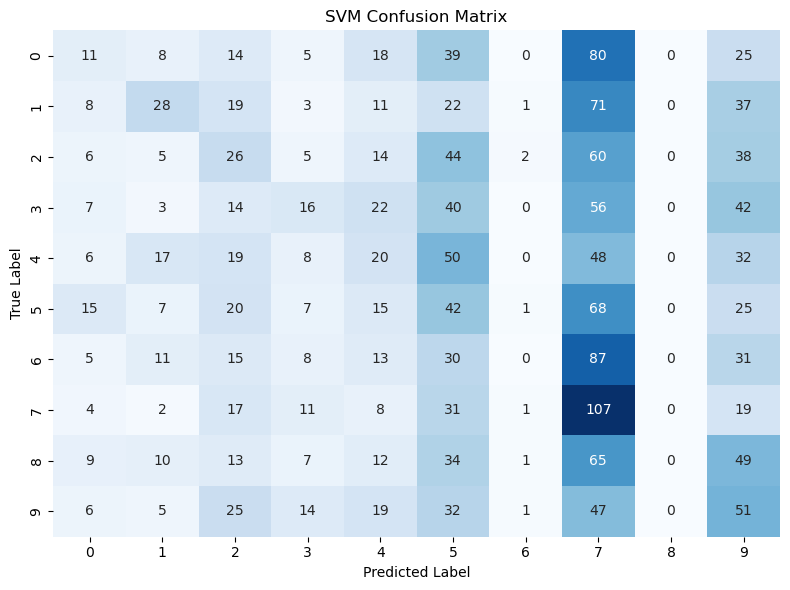

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.tight_layout()
plt.show()


#### **1.3.3 Accuracy Comparison Chart**

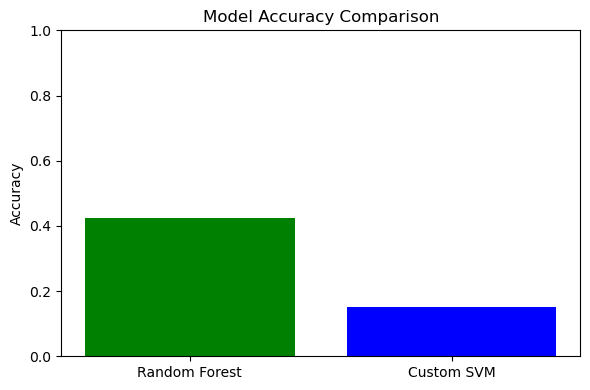

In [24]:
import matplotlib.pyplot as plt

# Accuracy values
rf_acc = 0.4235
svm_acc = 0.1505

# Labels and values
models = ['Random Forest', 'Custom SVM']
accuracies = [rf_acc, svm_acc]

# Plot
plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color=['green', 'blue'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()

#### **1.3.3 Confusion Matricies Side by Side**

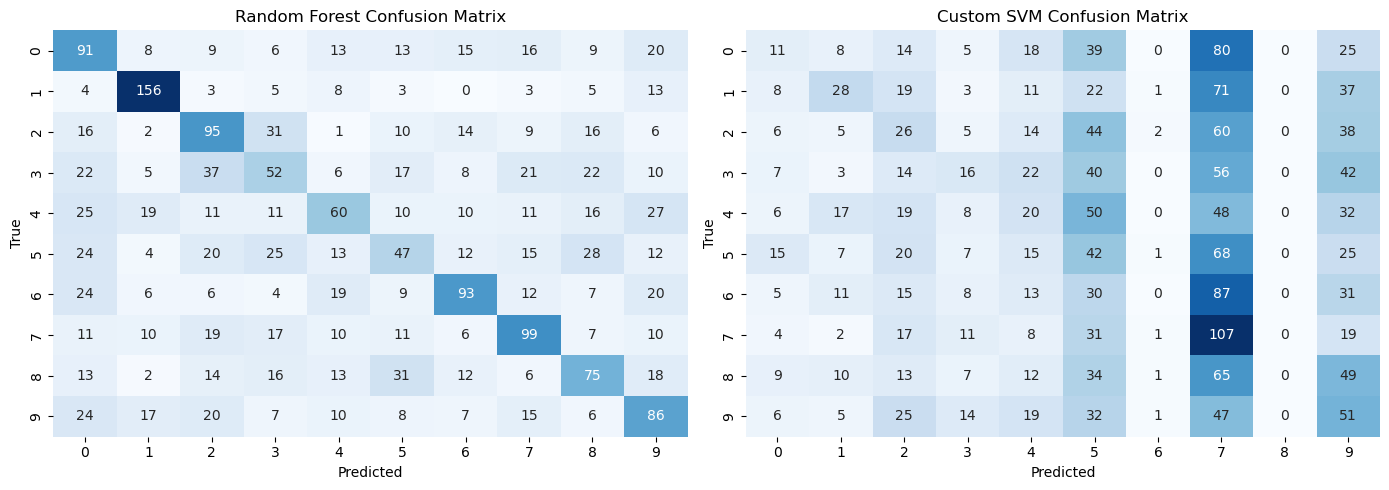

In [25]:
# Assuming conf_mat and conf_mat_svm already defined
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10), ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10), ax=axes[1])
axes[1].set_title('Custom SVM Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


#### **1.3.4 Preprocess data (Torch Tensors)**

In [26]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Reshape X to (N, 1, 28, 28) and normalize to [0, 1]
X = X_sampled.to_numpy().reshape(-1, 1, 28, 28).astype('float32') / 255.0
y = y_sampled.to_numpy().astype('int64')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

# Wrap in DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

#### **1.3.4 Define CNN**

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28 → 14
        x = self.pool(F.relu(self.conv2(x)))  # 14 → 7
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### **1.3.4 Train CNN**

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # Can adjust epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

Epoch 1, Loss: 87.8628
Epoch 2, Loss: 21.2326
Epoch 3, Loss: 12.9205
Epoch 4, Loss: 9.5979
Epoch 5, Loss: 7.7982
Epoch 6, Loss: 5.8069
Epoch 7, Loss: 4.7054
Epoch 8, Loss: 3.7017
Epoch 9, Loss: 2.5325
Epoch 10, Loss: 2.1369


#### **1.3.4 Evaluation of CNN**

In [29]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute metrics
acc_cnn = accuracy_score(all_labels, all_preds)
prec_macro_cnn = precision_score(all_labels, all_preds, average='macro')
recall_macro_cnn = recall_score(all_labels, all_preds, average='macro')
f1_macro_cnn = f1_score(all_labels, all_preds, average='macro')
f1_weighted_cnn = f1_score(all_labels, all_preds, average='weighted')

# Confusion matrix
conf_mat_cnn = confusion_matrix(all_labels, all_preds)

# Print results
print(f"CNN Accuracy: {acc_cnn:.4f}")
print(f"Macro Precision: {prec_macro_cnn:.4f}")
print(f"Macro Recall: {recall_macro_cnn:.4f}")
print(f"Macro F1-score: {f1_macro_cnn:.4f}")
print(f"Weighted F1-score: {f1_weighted_cnn:.4f}")

CNN Accuracy: 0.9730
Macro Precision: 0.9736
Macro Recall: 0.9730
Macro F1-score: 0.9730
Weighted F1-score: 0.9730


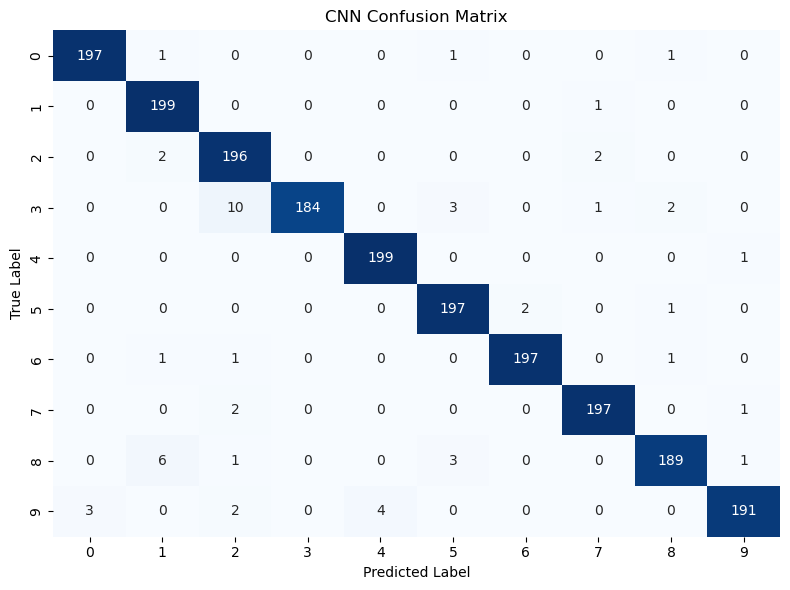

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_cnn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Confusion Matrix')
plt.tight_layout()
plt.show()
